In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score , confusion_matrix
from torchvision.models import VGG16_Weights
import seaborn as sns

# Upload & Read Data

In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 150
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
MSS_train = '/content/drive/MyDrive/MSS_train'
MSI_train = '/content/drive/MyDrive/MSI_train'

In [ ]:
print(f'Number of Microsatellite Stability images - train folder: {len(os.listdir(MSS_train))}')
print(f'Number of Microsatellite Instability - train folder: {len(os.listdir(MSI_train))}')

Number of Microsatellite Stability images - train folder: 596
Number of Microsatellite Instability - train folder: 603


In [ ]:
MSS_test = '/content/drive/MyDrive/MSS_test'
MSI_test = '/content/drive/MyDrive/MSI_test'

In [ ]:
print(f'Number of Microsatellite Stability images - test folder: {len(os.listdir(MSS_test))}')
print(f'Number of Microsatellite Instability images - test folder: {len(os.listdir(MSI_test))}')

Number of Microsatellite Stability images - test folder: 403
Number of Microsatellite Instability images - test folder: 463


In [ ]:
MSS_val = '/content/drive/MyDrive/MSS_val'
MSI_val = '/content/drive/MyDrive/MSI_val'

In [ ]:
print(f'Number of Microsatellite Stability images - val folder: {len(os.listdir(MSS_val))}')
print(f'Number of Microsatellite Instability images - val folder: {len(os.listdir(MSI_val))}')

Number of Microsatellite Stability images - val folder: 210
Number of Microsatellite Instability images - val folder: 205


**Defining Data augmentation and normalization for training using transforms**

> Resize image to (224, 244)

> Normalize the image demistion to (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

**Load the datasets with ImageFolder**

In [ ]:
# ImageFolder
train_data = ImageFolder(root='/content/drive/MyDrive/train_GC', transform=data_transforms)
test_data = ImageFolder(root='/content/drive/MyDrive/test_GC', transform=data_transforms)
val_data = ImageFolder(root='/content/drive/MyDrive/val_GC', transform=data_transforms)

# **Create a classifier using pre-trained model from pytorch - AlexNet**


# **On Val Test**

First combination lr= 0.003  wd=0.001 momentom=0.5 batch size= 64

In [ ]:
# data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 117MB/s]


Epoch 0/9, Loss: 0.8530, Train Accuracy: 0.4996
Epoch 1/9, Loss: 0.6783, Train Accuracy: 0.5571
Epoch 2/9, Loss: 0.6586, Train Accuracy: 0.6205
Epoch 3/9, Loss: 0.6488, Train Accuracy: 0.6364
Epoch 4/9, Loss: 0.6333, Train Accuracy: 0.6530
Epoch 5/9, Loss: 0.6007, Train Accuracy: 0.6756
Epoch 6/9, Loss: 0.6100, Train Accuracy: 0.6731
Epoch 7/9, Loss: 0.5706, Train Accuracy: 0.7039
Epoch 8/9, Loss: 0.5527, Train Accuracy: 0.7223
Epoch 9/9, Loss: 0.5541, Train Accuracy: 0.7273
Training Accuracy: 0.7273


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6169


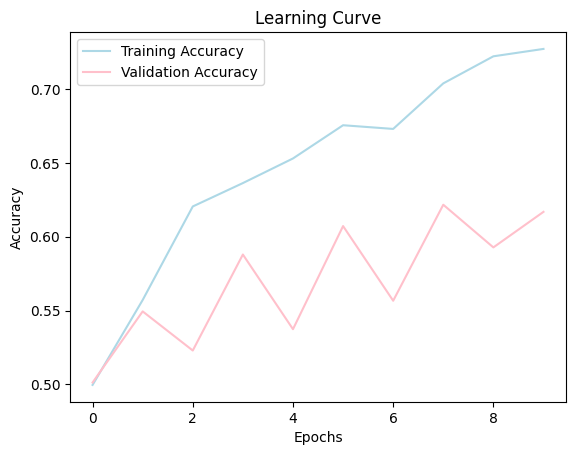

Training Accuracy: 0.7273
Validation Accuracy: 0.6169


In [ ]:
#learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Second combination lr= 0.001 wd=0.005 momentom=0.7 batch size= 32

In [ ]:
# data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.7447, Train Accuracy: 0.5196
Epoch 1/9, Loss: 0.6769, Train Accuracy: 0.5822
Epoch 2/9, Loss: 0.6561, Train Accuracy: 0.6097
Epoch 3/9, Loss: 0.6422, Train Accuracy: 0.6447
Epoch 4/9, Loss: 0.6027, Train Accuracy: 0.6706
Epoch 5/9, Loss: 0.5801, Train Accuracy: 0.7006
Epoch 6/9, Loss: 0.5510, Train Accuracy: 0.7206
Epoch 7/9, Loss: 0.5463, Train Accuracy: 0.7289
Epoch 8/9, Loss: 0.5401, Train Accuracy: 0.7323
Epoch 9/9, Loss: 0.4789, Train Accuracy: 0.7723
Training Accuracy: 0.7723


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6627


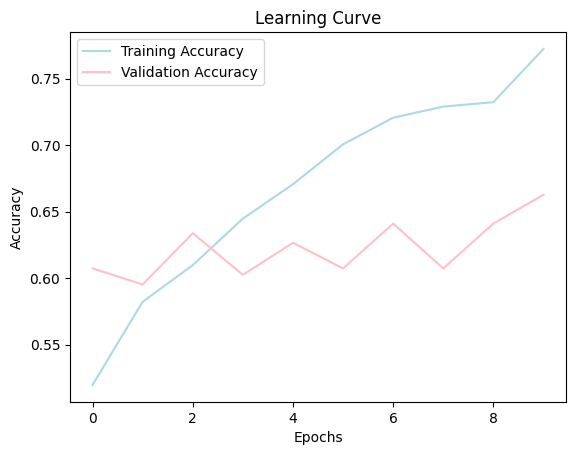

Training Accuracy: 0.7723
Validation Accuracy: 0.6627


In [ ]:
# learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Third combination lr= 0.001 wd=0.01 momentom=0.7 batch size= 64

In [ ]:
# data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.7)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.7806, Train Accuracy: 0.5246
Epoch 1/9, Loss: 0.6664, Train Accuracy: 0.5972
Epoch 2/9, Loss: 0.6500, Train Accuracy: 0.6230
Epoch 3/9, Loss: 0.6273, Train Accuracy: 0.6647
Epoch 4/9, Loss: 0.6093, Train Accuracy: 0.6714
Epoch 5/9, Loss: 0.5985, Train Accuracy: 0.6597
Epoch 6/9, Loss: 0.5828, Train Accuracy: 0.6881
Epoch 7/9, Loss: 0.5676, Train Accuracy: 0.6997
Epoch 8/9, Loss: 0.5785, Train Accuracy: 0.6997
Epoch 9/9, Loss: 0.5439, Train Accuracy: 0.7389
Training Accuracy: 0.7389


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6530


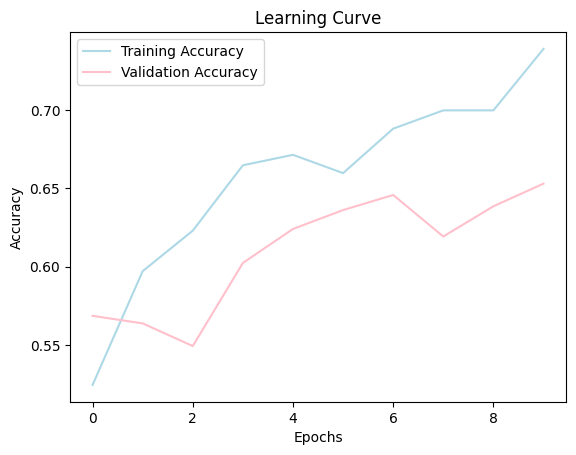

Training Accuracy: 0.7389
Validation Accuracy: 0.6530


In [ ]:
# learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Fourth combination lr= 0.003 wd=0.001 momentom=0.5 batch size= 128

In [ ]:
#data loaders with batch size 128
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Modify the classifier for classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

   # val
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.8880, Train Accuracy: 0.4754
Epoch 1/9, Loss: 0.6757, Train Accuracy: 0.5905
Epoch 2/9, Loss: 0.6552, Train Accuracy: 0.6305
Epoch 3/9, Loss: 0.6700, Train Accuracy: 0.6022
Epoch 4/9, Loss: 0.6459, Train Accuracy: 0.6205
Epoch 5/9, Loss: 0.6209, Train Accuracy: 0.6672
Epoch 6/9, Loss: 0.6113, Train Accuracy: 0.6639
Epoch 7/9, Loss: 0.5936, Train Accuracy: 0.6831
Epoch 8/9, Loss: 0.5941, Train Accuracy: 0.6897
Epoch 9/9, Loss: 0.5668, Train Accuracy: 0.7089
Training Accuracy: 0.7089


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6096


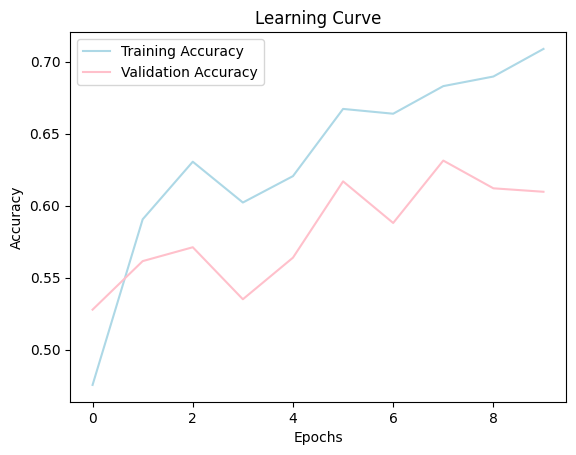

Training Accuracy: 0.7089
Validation Accuracy: 0.6096


In [ ]:
#learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

# **On Test Set**

In [ ]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#AlexNet model
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)

# model parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.7)

# Training
num_epochs = 10

train_accuracies = []
test_accuracies = []

# Start training time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

# Calculate training time
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/your_trained_model.pth')

# final training accuracy
print(f'Training Accuracy: {train_accuracies[-1]:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

Number of parameters in the model: 57012034
Epoch 0/9, Loss: 0.7240, Train Accuracy: 0.5413
Epoch 1/9, Loss: 0.6518, Train Accuracy: 0.6163
Epoch 2/9, Loss: 0.6466, Train Accuracy: 0.6163
Epoch 3/9, Loss: 0.6101, Train Accuracy: 0.6664
Epoch 4/9, Loss: 0.5790, Train Accuracy: 0.7048
Epoch 5/9, Loss: 0.5670, Train Accuracy: 0.7314
Epoch 6/9, Loss: 0.5400, Train Accuracy: 0.7239
Epoch 7/9, Loss: 0.5227, Train Accuracy: 0.7389
Epoch 8/9, Loss: 0.4990, Train Accuracy: 0.7440
Epoch 9/9, Loss: 0.4792, Train Accuracy: 0.7840
Total training time: 1216.92 seconds
Training Accuracy: 0.7840
Confusion Matrix:
[[217 246]
 [ 68 335]]


In [ ]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on Test Set: {overall_accuracy:.4f}')

# Calculate classification report
class_report = classification_report(all_labels, all_preds)
print(f'Classification Report:\n{class_report}')

Overall Accuracy on Test Set: 0.6374
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.47      0.58       463
           1       0.58      0.83      0.68       403

    accuracy                           0.64       866
   macro avg       0.67      0.65      0.63       866
weighted avg       0.68      0.64      0.63       866



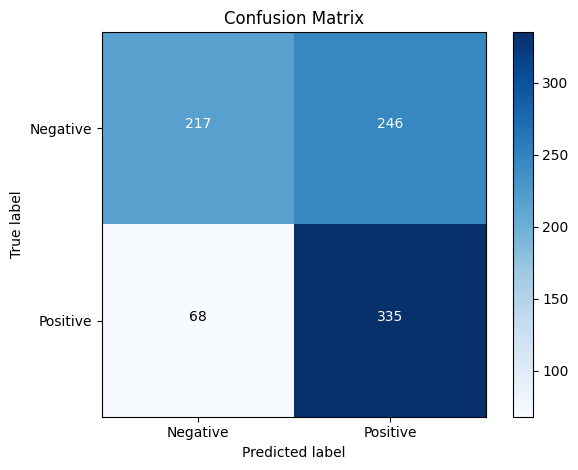

In [ ]:
# confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# labels
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


# **Interface**

Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQSNLFLWKRDR-TCGA-CM-4743-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQLWTDNCDGIM-TCGA-CM-6171-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQIGPHSNLCHK-TCGA-QG-A5Z2-01Z-00-DX2.jpg, Predicted Class: MSI
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQTISQRRTKGR-TCGA-G4-6304-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQMWRCKLLDEK-TCGA-NH-A5IV-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQVCIQDISFQG-TCGA-D5-6530-01Z-00-DX1.jpg, Predicted Class: MSI
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-APGGPNEMRKYR-TCGA-AA-3968-01Z-00-DX1.jpg, Predicted Class: MSI
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-APGHEMNKGGLK-TCGA-A6-61

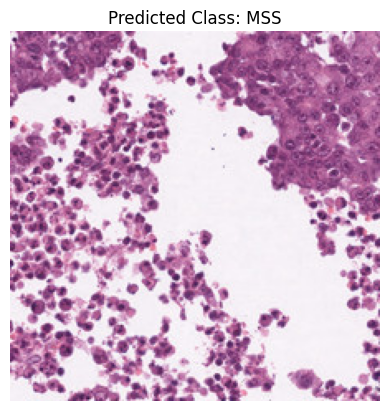

Predicted class: MSS


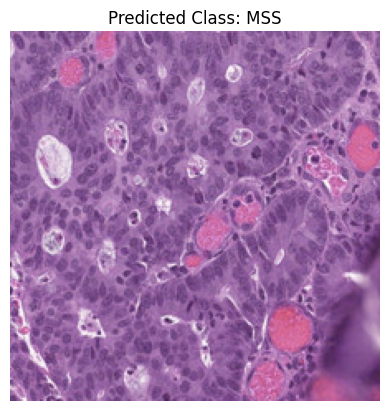

Predicted class: MSI


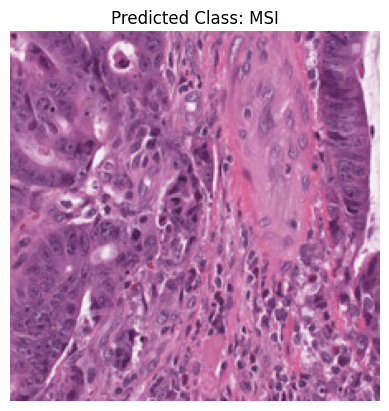

Predicted class: MSS


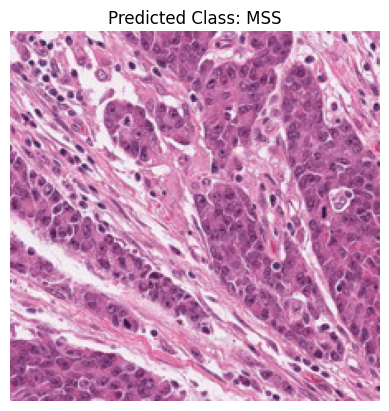

Predicted class: MSS


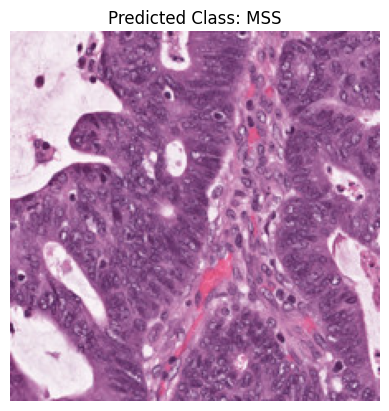

Predicted class: MSI


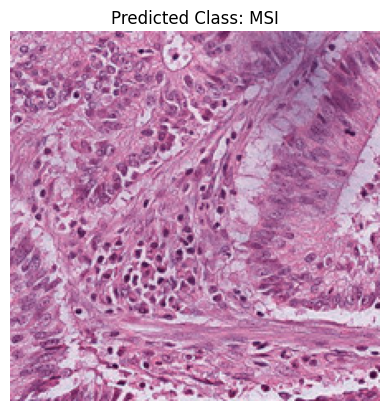

Predicted class: MSI


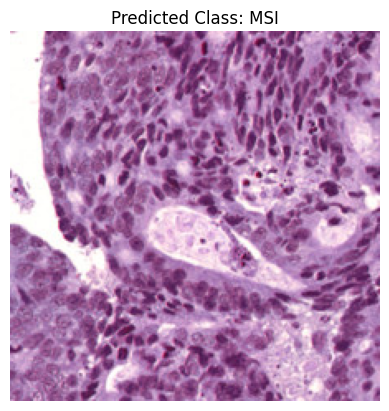

Predicted class: MSI


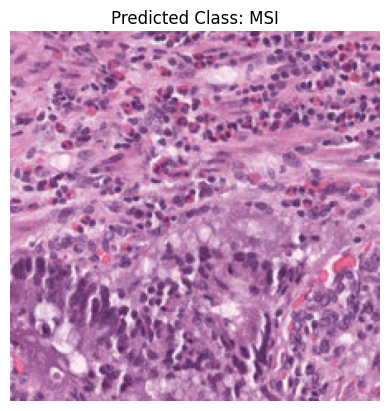

Predicted class: MSS


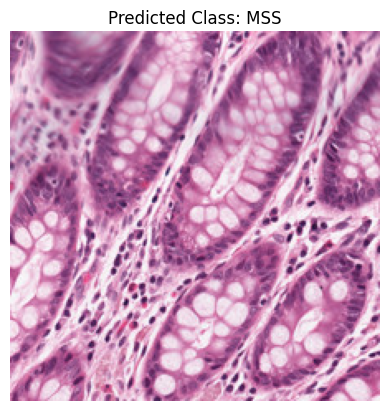

Predicted class: MSI


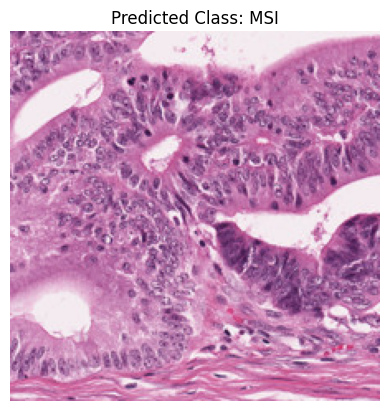

Predicted class: MSI


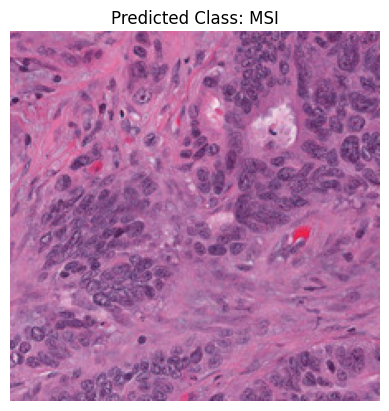

Predicted class: MSS


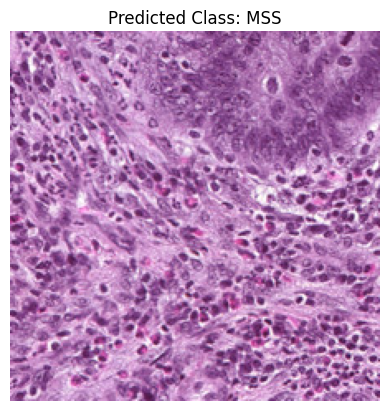

In [ ]:
import os

input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = models.alexnet(weights=None)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/your_trained_model.pth'))
model.eval()

classes = ['MSS', 'MSI']

def predict_image(file_path):
    # Print file path
    #print("Processing image:", file_path)

    img = Image.open(file_path)
    img = input_transform(img)
    img = img.unsqueeze(0)

    # prediction
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted.item()]

    print("Predicted class:", predicted_class)

    return predicted_class

# Directory containing images to classify
image_dir = '/content/drive/MyDrive/load images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

for image_file in image_files:
    prediction = predict_image(image_file)
    print(f"Image: {image_file}, Predicted Class: {prediction}")


import matplotlib.pyplot as plt

def show_prediction(file_path, predicted_class):
    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

for image_file in image_files:
    prediction = predict_image(image_file)
    show_prediction(image_file, prediction)